=== Analytical vs Monte Carlo Option Pricing ===
Underlying price (S): 100
Strike price (K): 95
Time to maturity in YEARS (T): 2
Risk-free rate (e.g., 0.05): 0.03
Volatility (e.g., 0.20): 0.3
Call or Put? put
Number of Monte Carlo simulations (default=100000): 10000

=== PRICE COMPARISON ===
Analytical Price : 11.1844
Monte Carlo Price: 10.8868 (SE ~ 0.1536)

=== GREEKS ===
Delta : -0.3176
Gamma : 0.008402
Vega  : 50.4132
Theta : -2.4927
Rho   : -85.8864


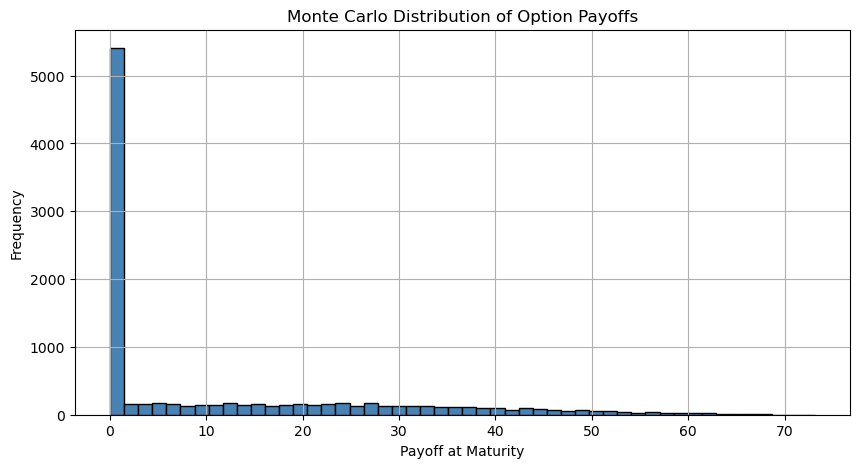

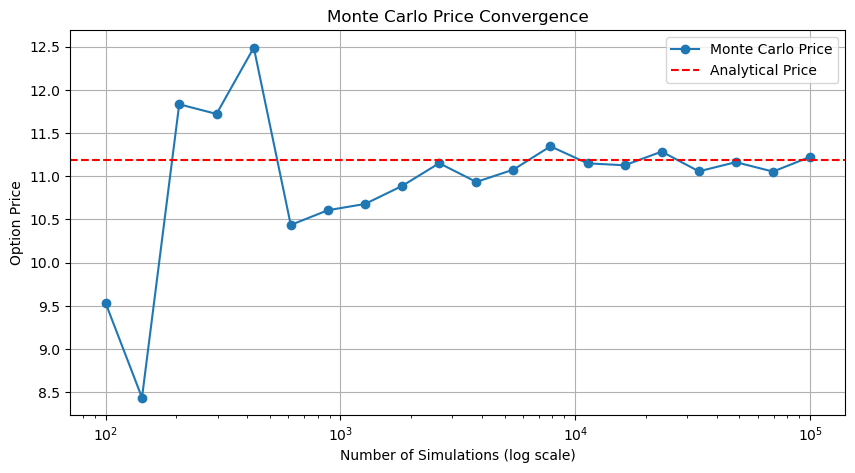


Images saved as:
 - mc_payoffs.png
 - mc_convergence.png
CSV exported to: option_mc_results.csv


In [16]:
import math
import numpy as np
import csv
import os
import datetime
import matplotlib.pyplot as plt

# Try importing scipy for normal CDF, fallback to erf
try:
    from scipy.stats import norm
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False


# ------------------------
# Utility functions
# ------------------------

def normal_cdf(x):
    if SCIPY_AVAILABLE:
        return norm.cdf(x)
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def normal_pdf(x):
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)


# ------------------------
# Black-Scholes core formulas
# ------------------------

def _d1(S, K, T, r, sigma):
    return (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * math.sqrt(T))

def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * math.sqrt(T)

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    option_type = option_type.lower()
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)

    if option_type == "call":
        return S * normal_cdf(d1) - K * math.exp(-r*T) * normal_cdf(d2)
    else:
        return K * math.exp(-r*T) * normal_cdf(-d2) - S * normal_cdf(-d1)

def delta(S, K, T, r, sigma, option_type="call"):
    d1 = _d1(S, K, T, r, sigma)
    return normal_cdf(d1) if option_type == "call" else normal_cdf(d1) - 1

def gamma(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    return normal_pdf(d1) / (S * sigma * math.sqrt(T))

def vega(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    return S * math.sqrt(T) * normal_pdf(d1)

def theta(S, K, T, r, sigma, option_type="call"):
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)
    first = -(S * normal_pdf(d1) * sigma) / (2 * math.sqrt(T))

    if option_type == "call":
        second = -r * K * math.exp(-r*T) * normal_cdf(d2)
        return first + second
    else:
        second = r * K * math.exp(-r*T) * normal_cdf(-d2)
        return first + second

def rho(S, K, T, r, sigma, option_type="call"):
    d2 = _d2(S, K, T, r, sigma)
    if option_type == "call":
        return K * T * math.exp(-r*T) * normal_cdf(d2)
    else:
        return -K * T * math.exp(-r*T) * normal_cdf(-d2)


# ------------------------
# Monte Carlo pricer
# ------------------------

def monte_carlo_european(S, K, T, r, sigma, option_type="call", n_sims=100000):
    Z = np.random.normal(0.0, 1.0, n_sims)
    ST = S * np.exp((r - 0.5*sigma**2)*T + sigma * math.sqrt(T) * Z)

    if option_type == "call":
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)

    discounted = np.exp(-r*T) * payoffs
    mc_price = discounted.mean()
    mc_se = discounted.std(ddof=1) / math.sqrt(n_sims)

    return mc_price, mc_se, payoffs, ST


# ------------------------
# USER INPUT
# ------------------------

print("=== Analytical vs Monte Carlo Option Pricing ===")

S = float(input("Underlying price (S): "))
K = float(input("Strike price (K): "))
T = float(input("Time to maturity in YEARS (T): "))
r = float(input("Risk-free rate (e.g., 0.05): "))
sigma = float(input("Volatility (e.g., 0.20): "))
option_type = input("Call or Put? ").strip().lower()
n_sims_str = input("Number of Monte Carlo simulations (default=100000): ").strip()
n_sims = int(n_sims_str) if n_sims_str else 100000


# ------------------------
# CALCULATIONS
# ------------------------

analytic_price = black_scholes_price(S, K, T, r, sigma, option_type)
mc_price, mc_se, payoffs, ST = monte_carlo_european(S, K, T, r, sigma, option_type, n_sims)

# Greeks
d = delta(S, K, T, r, sigma, option_type)
g = gamma(S, K, T, r, sigma)
v = vega(S, K, T, r, sigma)
t = theta(S, K, T, r, sigma, option_type)
rh = rho(S, K, T, r, sigma, option_type)


# ------------------------
# OUTPUT
# ------------------------

print("\n=== PRICE COMPARISON ===")
print(f"Analytical Price : {analytic_price:.4f}")
print(f"Monte Carlo Price: {mc_price:.4f} (SE ~ {mc_se:.4f})")

print("\n=== GREEKS ===")
print(f"Delta : {d:.4f}")
print(f"Gamma : {g:.6f}")
print(f"Vega  : {v:.4f}")
print(f"Theta : {t:.4f}")
print(f"Rho   : {rh:.4f}")


# ------------------------
# GRAPH 1: PAYOFF DISTRIBUTION (SAVE IMAGE)
# ------------------------

plt.figure(figsize=(10,5))
plt.hist(payoffs, bins=50, color='steelblue', edgecolor='black')
plt.title("Monte Carlo Distribution of Option Payoffs")
plt.xlabel("Payoff at Maturity")
plt.ylabel("Frequency")
plt.grid(True)

# Save the image
plt.savefig("mc_payoffs.png", dpi=300)
plt.show()


# ------------------------
# GRAPH 2: PRICE CONVERGENCE (SAVE IMAGE)
# ------------------------

sim_counts = np.logspace(2, 5, 20).astype(int)  # 100 → 100,000
mc_estimates = []

for n in sim_counts:
    mc_p, _, _, _ = monte_carlo_european(S, K, T, r, sigma, option_type, n)
    mc_estimates.append(mc_p)

plt.figure(figsize=(10,5))
plt.plot(sim_counts, mc_estimates, marker='o', label="Monte Carlo Price")
plt.axhline(analytic_price, color='red', linestyle='--', label="Analytical Price")
plt.xscale("log")
plt.xlabel("Number of Simulations (log scale)")
plt.ylabel("Option Price")
plt.title("Monte Carlo Price Convergence")
plt.grid(True)
plt.legend()

# Save the image
plt.savefig("mc_convergence.png", dpi=300)
plt.show()


# ------------------------
# EXPORT TO CSV
# ------------------------

csv_file = "option_mc_results.csv"

headers = [
    "timestamp", "option_type", "S", "K", "T", "r", "sigma", "n_sims",
    "analytic_price", "mc_price", "mc_standard_error",
    "delta", "gamma", "vega", "theta", "rho"
]

row = [
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    option_type, S, K, T, r, sigma, n_sims,
    analytic_price, mc_price, mc_se,
    d, g, v, t, rh
]

write_header = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(headers)
    writer.writerow(row)

print("\nImages saved as:")
print(" - mc_payoffs.png")
print(" - mc_convergence.png")
print(f"CSV exported to: {csv_file}")
